# Wisconsin Card Sort

The following experiment learns to solve the Wisconsin Card Sort via reinforcement learning

In [1]:
from tensorflow.keras.layers import Input, Dense, Flatten
import tensorflow as tf

import numpy as np

from ntask.atrs import AtrModel, AtrMovingAverage
from ntask.callbacks import AtrLogger
from ntask.layers import Context
from ntask.models import NTaskModel
from ntask.flags import Verbosity
from ntask.utils import set_seed

In [2]:
def harmonic_mean(x):
    return 1 / tf.math.reduce_mean(1/x)
    
def standard_deviation(x, mean):
    return tf.math.sqrt(tf.math.reduce_mean(tf.math.square(x - mean)))

In [15]:
class AtrSwitch(AtrMovingAverage):
    def context_loss_fn(self, context_delta):
        return tf.reduce_mean(context_delta)

In [4]:
def random_card():
    """
    Generate a one-hot encoded card.
    Returns a tuple of the card and the expected output label
    """
    x = np.identity(3)
    np.random.shuffle(x)
    return x

In [5]:
def policy(predicted, epsilon):
    if np.random.random() < epsilon:
        return np.random.randint(3), True
    return np.argmax(predicted), False

In [81]:
def reward(sort, rule):
    if sort == rule:
        return 5.0
    return 0.0

In [82]:
def episode(model, rule, ep, epsilon=0.01, alpha=0.5, gamma=0.95, callbacks=[]):
    
    print(f"{ep}:")
    
    # Action choices
    actions = np.identity(3)
    
    # Random card to sort
    card = random_card()
    
    # Create the possible inputs to feed into the neural network
    inputs = np.array([np.vstack((a, card)) for a in actions])
    
    # Predict and sort
    values = model.predict(inputs)
    sort, is_random = policy(values.flatten(), epsilon)
    r = reward(sort, rule)
    
    if is_random:
        print(f"{ep} Random action taken")
        
    
    # Q-learning update
    print(values.flatten(), end="")
    q_old = values[sort][0]
    values[sort][0] = values[sort][0] + alpha*(r - q_old)
    print(values.flatten())
    
    # Fit to the reward first then the other action possibilities.
    # This attepmts to prevent interference in the other action choices
    values[0], values[sort] = values[sort], values[0]
    inputs[0], inputs[sort] = inputs[sort], inputs[0]
    
    model.fit(inputs, values, train_after_switch=False, find_best_fit=False, batch_size=1, callbacks=callbacks, verbose=Verbosity.Contexts)
    
    return sort == rule, is_random

In [83]:
def wisconsin_card_sort(model, episodes, seq_correct=3, epsilon=0.01, alpha=0.5, gamma=0.95, callbacks=[], initial_shuffle=False, shuffle=True):
    NUM_DIMENSIONS = 3
    rule = 0 if not initial_shuffle else np.random.randint(NUM_DIMENSIONS)
    tried_all = False
    correct = 0
    print("Rule is:", rule)
    for ep in range(episodes):
        # Perform the episode. Count the sequentially correct episodes
        is_correct, is_random = episode(model, rule, ep, epsilon, alpha, gamma, callbacks)
        if is_correct:
            correct += 1
        else:
            correct = 0
            
        # Change the rule once the model has learned the rule
        if correct >= seq_correct:
            correct = 0
            if shuffle and (initial_shuffle or tried_all):
                oldrule = rule
                while rule == oldrule:
                    rule = np.random.randint(NUM_DIMENSIONS)
            else:
                if rule + 1 == NUM_DIMENSIONS:
                    tried_all = True
                rule = (rule + 1) % NUM_DIMENSIONS
            print(f"\nEpisode: {ep+1}; New rule is:", rule, '\n')

## Static n-task Learning

In [84]:
set_seed(1)

In [93]:
# Optimizer
# optimizer = tf.keras.optimizers.SGD(1e-2)
# optimizer = tf.keras.optimizers.Adam(1e-3)

# Hyperparameters
# hrr_size = 256
# num_contexts = 3
# switch_threshold = -3
# n_periods = 10

# Model Architecture
# inp = Input((4,3))
# x = Flatten()(inp)
# x = Dense(hrr_size, activation="relu", use_bias=False)(x)
# x = Context(num_contexts, AtrMovingAverage(switch_threshold))(x)
# x = Dense(1, activation="linear", use_bias=False)(x)

# Create the model
# model = NTaskModel(inputs=inp, outputs=x)

# Compile the model
# model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=optimizer)

In [94]:
# Optimizer
# optimizer = tf.keras.optimizers.SGD(1e-1)
optimizer = tf.keras.optimizers.Adam(1e-2)

# Hyperparameters
hrr_size = 512
num_contexts = 3
switch_threshold = -2
n_periods = 10

# Model Architecture
inp = Input((4,3))
x = Flatten()(inp)
x = Dense(hrr_size, activation="relu", use_bias=False)(x)
# x = Context(num_contexts, AtrMovingAverage(switch_threshold))(x)
x = Context(num_contexts, AtrSwitch(switch_threshold))(x)
x = Dense(1, activation="linear", use_bias=False)(x)

# Create the model
model = NTaskModel(inputs=inp, outputs=x)

# Compile the model
model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=optimizer)

In [95]:
episodes = 189
seq_correct = 30
epsilon = 0.05
alpha = 1.0
gamma = 0.75

logger = AtrLogger(track_epochs_internally=True)
callbacks = [logger]

wisconsin_card_sort(model, episodes, seq_correct, epsilon, alpha, gamma, callbacks)

Rule is: 0
0:
[-0.18807644 -0.22392571 -0.12395664][-0.18807644 -0.22392571  0.        ]
1:
[ 0.01148551 -0.04989696  0.04673159][ 0.01148551 -0.04989696  0.        ]
2:
[-0.07772859 -0.16261193 -0.16715093][ 5.         -0.16261193 -0.16715093]
3:
3 Random action taken
[-0.34036058 -0.4100292  -0.4934249 ][ 5.        -0.4100292 -0.4934249]
4:
[ 0.07005352 -0.2722252  -0.6034812 ][ 5.        -0.2722252 -0.6034812]
5:
[1.2354853  0.6327301  0.16782749][5.         0.6327301  0.16782749]
6:
[ 1.5429568  0.6192369 -0.0652847][ 5.         0.6192369 -0.0652847]
7:
[3.0077574  1.6171017  0.74430764][5.         1.6171017  0.74430764]
8:
[4.1807814  2.1811159  0.76334697][5.         2.1811159  0.76334697]
9:
[6.040708  3.3786821 1.4901502][5.        3.3786821 1.4901502]
10:
[4.7084618  1.9431951  0.30589917][5.         1.9431951  0.30589917]
11:
[7.389406  4.251066  1.6502271][5.        4.251066  1.6502271]
12:
[7.7066817 4.9281383 2.4607263][5.        4.9281383 2.4607263]
13:
[6.1613474 3.57973

KeyboardInterrupt: 

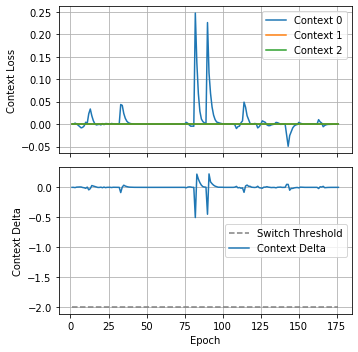

In [96]:
logger.plot(figsize=(5,5))

## 2. Dynamic n-Task

In [52]:
set_seed(2)

In [53]:
# Optimizer
# optimizer = tf.keras.optimizers.SGD(1e-1)
optimizer = tf.keras.optimizers.Adam(1e-2)

# Hyperparameters
hrr_size = 64
num_contexts = 3
switch_threshold = -1.5
add_threshold = -1.75
n_periods = 10

# Model Architecture
inp = Input((3,3))
x = Flatten()(inp)
x = Dense(hrr_size, activation="relu", use_bias=False)(x)
x = Context(1, AtrMovingAverage(switch_threshold, add_threshold=add_threshold, max_contexts=num_contexts))(x)
x = Dense(3, activation="linear", use_bias=False)(x)

# Create the model
model = NTaskModel(inputs=inp, outputs=x)

# Compile the model
model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=optimizer)

In [54]:
episodes = 1000
seq_correct = 30
epsilon = 0.1
alpha = 1.0
gamma = 0.75

logger = AtrLogger(track_epochs_internally=True)
callbacks = [logger]

wisconsin_card_sort(model, episodes, seq_correct, epsilon, alpha, gamma, callbacks)

Rule is: 0
0: Random action taken
[-0.3592347  -0.01275272 -0.35699028] => [[-0.3592347  -0.01275272 -5.        ]]
1: [-0.05000715  0.21451156 -0.32315254] => [[-0.05000715 -5.         -0.32315254]]
2: [-0.0405277   0.01484657 -0.38585615] => [[-0.0405277  -5.         -0.38585615]]
3: [-0.27865526 -0.16699988  0.3656221 ] => [[-0.27865526 -0.16699988 -5.        ]]
4: [ 0.08725923 -0.25249815 -0.25822014] => [[ 5.         -0.25249815 -0.25822014]]
5: [-0.22938381 -0.3106256   0.08568858] => [[-0.22938381 -0.3106256  -5.        ]]
6: [ 0.16855435 -0.4242655  -0.6251976 ] => [[ 5.        -0.4242655 -0.6251976]]
7: [ 0.4199217  -0.40170988 -0.3721623 ] => [[ 5.         -0.40170988 -0.3721623 ]]
8: [-0.06278826 -0.39798415 -1.2916626 ] => [[ 5.         -0.39798415 -1.2916626 ]]
9: [ 0.5567788 -0.4952971 -0.7582058] => [[ 5.        -0.4952971 -0.7582058]]
10: [ 0.09277569 -0.5790379  -0.5949466 ] => [[ 5.        -0.5790379 -0.5949466]]
11: [ 0.87836397 -0.54605263 -0.8154193 ] => [[ 5.      

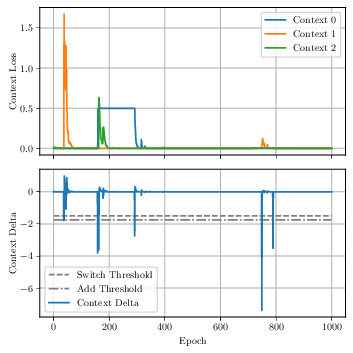

In [55]:
logger.plot(figsize=(5,5), savefile="graphs/wcst_dynamic.pgf")

## Dynamic n-task Learning

In [ ]:
set_seed(1)

In [ ]:
# Optimizer
optimizer = tf.keras.optimizers.SGD(1e-1)

# Hyperparameters
hrr_size = 128
num_contexts = 3
switch_threshold = -0.01
add_threshold = -0.015
n_periods = 10

# Model Architecture
inp = Input((3,4))
x = Flatten()(inp)
x = Dense(hrr_size, activation="relu")(x)
x = Context(1, AtrMovingAverage(switch_threshold, add_threshold, num_contexts))(x)
x = Dense(4, activation="linear")(x)

# Create the model
model = NTaskModel(inputs=inp, outputs=x)

# Compile the model
model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=optimizer)

In [ ]:
episodes = 400
seq_correct = 20
epsilon = 0.00
alpha = 1.0
gamma = 0.75

logger = AtrLogger(track_epochs_internally=True)
callbacks = [logger]

wisconsin_card_sort(model, episodes, seq_correct, epsilon, alpha, gamma, callbacks)

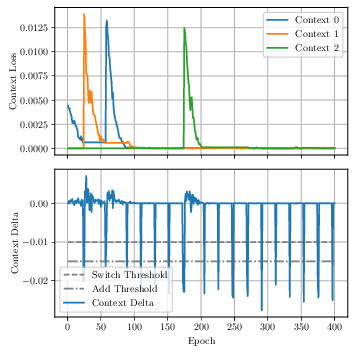

In [61]:
logger.plot(figsize=(5,5), savefile="graphs/wcst_dynamic.pgf")